# Compte Rendu Projet - Fabien Behra

Voici le compte rendu du projet du module Documents Multimédia & Recherche.
Il contient le détail des travaux réalisés tout le long de ce projet, les étapes de réflexions, les résultats, les echecs...
Tous les travaux ont été réalisés par Fabien Behra.

- [x]  Fonction spécifique pour le calcul de l'erreur (ou de la précision) globale sur l'ensemble de test
- [x]  Appel de cette fonction avant la première itération (époque) et après chaque itération
- [x]  Affichage de l'évolution de l'erreur (ou de la précision) globale en fonction des itérations
- [ ]  Essais de modification de l'architecture du réseau (taille, nombre et/ou types des couches) ou de conditions d'apprentissage (augmentation de données)
- [ ]  Description complète de votre réseau final avec : nombre de couches et sous-couches, identification de toutes les variables intermédiaires (les “Xn”) de l'entrée à la sortie et en donnant leurs dimensions (tailles de tenseurs) ; identification de toutes les fonctions successives (les “Fn”) avec leurs types ; et identification de tous les paramètres de ces fonctions (les “Wn”), en donnant leurs dimensions (tailles de tenseurs) et en précisant éventuellement s'ils sont nuls (pas de paramètres pour la fonction correspondante).
- [ ]  Calcul du nombre d'opérations flottantes effectuées pour les passes avant (le nombre d'opérations pour les passes arrières, quand il y en a, est quasiment le même) pour une image ; on comptera une opération pour une addition, pour une multiplication ou pour un maximum, même si ces opérations sont de complexités différentes.
- [ ]  Calcul du nombre total d'opérations pour une époque, incluant les passes avant et arrière pour les images d'entraînement et uniquement une passe avant pour les images de test.
- [ ]  Même calcul pour l'entraînemenent et l'évaluation en continu sur l'ensemble des époques.
- [ ]  Calcul en nombre total d'opérations flottantes par seconde sur la durée d'entraînement.
- [ ]  Et, finalement, la meilleure performance obtenue avec les contraintes de nombre de paramètres et de temps d'entraînement.

## Jeu d'entrainement

### Définition du jeu d'entrainement
Pour le jeu de test, on importe 10,000 images de 32px par 32px. 

In [9]:
import torch
import torchvision
import torchvision.transforms as transforms

#Augmentation de données
# Modification des images en entrée, (Crop, flip) pour augmenter la précision du réseau
transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.RandomCrop(32, padding=4),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#peut être augmenté pour être plus rapide -> Mettre + d'epochs
batch_size = 16

# jeu d'entrainement
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# Charge les images
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

# jeu de vérification
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# Classes à identifier
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


KeyboardInterrupt: 

### Verification de la bonne relation image - classe du jeu d'entrainement
On vérifie sur 16 images la bonne correspondance de la classe.

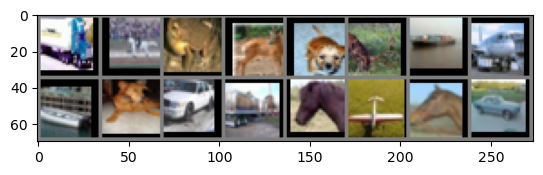

truck horse frog  deer  dog   deer  ship  plane ship  dog   car   truck horse plane horse car  


In [8]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## Définition des méthodes d'évaluation

In [7]:
# Méthode qui détermine la précision globale du réseau
def getNetworkAccuracy(net):
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total} %')

In [10]:
# Méthode qui détermine la précision du réseau pour chaque classe possible
def getClassAccuracy(net):
    # prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}
    net.eval()

    # again no gradients needed
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            #images, labels = data
            outputs = net(images)
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1


    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

## Définition de la méthode d'entrainement

In [1]:
# Définition de la méthode d'entrainement
import time

def trainNetwork(net):

    # démarre le timer général
    trainingStartTime = time.time()
    
    # Affiche la précision du réseau sans entrainement
    print('------ EPOCH 0 ---(Avg loss: NA)---------')
    getNetworkAccuracy(net)
    getClassAccuracy(net)

    # 110 epochs pour rester en dessous de l'heure d'entrainement
    rangeEpochs = range(110)
    for epoch in rangeEpochs:  # loop over the dataset multiple times
        # Démarre le timer pour une epoch
        basetime = time.time()
        running_loss = 0.0

        #On met le réseau en mode entrainement puisqu'on utilise des dropout et des batchNormalization
        net.train()
        
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()

        #On met le réseau en mode evaluation avant d'évaluer le réseau
        net.eval()
        print(f'------ EPOCH {epoch+1} : ({(time.time() - basetime):.2f}s)---(Avg loss:{running_loss/i:.3f})--------')
        getNetworkAccuracy(net)
        
        # pour la dernière epoch, on affiche la précision de chaque classe
        if epoch == rangeEpochs[-1]:
            getClassAccuracy(net)

    PATH = './cifar_net.pth'
    torch.save(net.state_dict(), PATH)
    print(f'Finished Training : ({(time.time() - trainingStartTime):.2f}s)')

## Définition du CNN initial

Voici le réseau initial, duquel je suis parti pour concevoir mon réseau final
```python
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120) 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
```

Il possède 62,000 paramètres

```
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
================================================================
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
================================================================
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.31
----------------------------------------------------------------
```

Pour une précision de 60% avec un AVG loss de 1.108 en 4 epoch

```
-------------EPOCH 0-------------
Accuracy of the network on the 10000 test images: 9 %
Accuracy for class: plane is 0.0 %
Accuracy for class: car   is 0.0 %
Accuracy for class: bird  is 0.0 %
Accuracy for class: cat   is 0.0 %
Accuracy for class: deer  is 0.0 %
Accuracy for class: dog   is 99.6 %
Accuracy for class: frog  is 0.0 %
Accuracy for class: horse is 0.0 %
Accuracy for class: ship  is 0.0 %
Accuracy for class: truck is 0.0 %

-------------EPOCH 1: time:(39.317s), AVG loss:(1.709)-------------
Accuracy of the network on the 10000 test images: 50 %

-------------EPOCH 2: time:(39.577s), AVG loss:(1.333)-------------
Accuracy of the network on the 10000 test images: 55 %

-------------EPOCH 3: time:(39.354s), AVG loss:(1.199)-------------
Accuracy of the network on the 10000 test images: 57 %

-------------EPOCH 4: time:(39.478s), AVG loss:(1.108)-------------
Accuracy of the network on the 10000 test images: 60 %
Accuracy for class: plane is 56.2 %
Accuracy for class: car   is 83.9 %
Accuracy for class: bird  is 33.3 %
Accuracy for class: cat   is 52.7 %
Accuracy for class: deer  is 54.3 %
Accuracy for class: dog   is 48.8 %
Accuracy for class: frog  is 67.5 %
Accuracy for class: horse is 69.4 %
Accuracy for class: ship  is 73.6 %
Accuracy for class: truck is 64.9 %
```


## Tests & améliorations effectués

### Test 1 : Découverte
Pour les premiers tests, je me suis contenté de modifier des chiffres aléatoirement mais avec une certaine logique tout de même. Pour ce test, voici les modifications:
- Passage d'une convolution de (3, 6, 5) -> (3, 18, 5) au départ
- Faire correspondre les bons chiffres pour la suite

```python
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 18, 5) # -> anciennement (3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(18, 54, 5) # -> anciennement (6, 16, 5)
        self.fc1 = nn.Linear(54 * 5 * 5, 120) 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
```

Paramètres & résultats
```
NB TOTAL PARAMETERS : 198856
torch.Size([18, 3, 5, 5])
torch.Size([18])
torch.Size([54, 18, 5, 5])
torch.Size([54])
torch.Size([120, 1350])
torch.Size([120])
torch.Size([84, 120])
torch.Size([84])
torch.Size([10, 84])
torch.Size([10])
-------SUMMARY-------
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
================================================================
            Conv2d-1           [-1, 18, 28, 28]           1,368
         MaxPool2d-2           [-1, 18, 14, 14]               0
            Conv2d-3           [-1, 54, 10, 10]          24,354
         MaxPool2d-4             [-1, 54, 5, 5]               0
            Linear-5                  [-1, 120]         162,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
================================================================
Total params: 198,856
Trainable params: 198,856
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.19
Params size (MB): 0.76
Estimated Total Size (MB): 0.96
----------------------------------------------------------------

RESULTS : Accuracy 56% 
Final loss: 1.277
```

### Test 2 : Ajout de convolutions
Avec le premier test peu concluant, mais avec 50k paramètres de marge, je décide donc de :
- changer les convolutions
- ajouter une convolution
- changer les fonctions linéaires
Sans trop d'objectifs, uniquement dans un but d'observation.

```python
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 12, 3) #entrée 32 tailles de couche -> 30 (32 - (3-1))
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(12, 32, 3) #entrée 30 -> 28
        self.conv3 = nn.Conv2d(32, 120, 3) #entrée 14 -> 12
        self.fc1 = nn.Linear(120 * 6 * 6, 50) #completement connectée
        self.fc2 = nn.Linear(50, 30)
        self.fc3 = nn.Linear(30, 10)

   def forward(self, x):

        x = F.relu(self.conv1(x)) # -> 15 taille de couche
        x = self.pool(F.relu(self.conv2(x))) # -> entrée 28 tailles -> 14 tailles 
        x = self.pool(F.relu(self.conv3(x))) # -> 14 -> 12 -> 6
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
```

Paramètres & Résultats
```
NB TOTAL PARAMETERS : 256394

------ EPOCH 1 : (34.20s)---(Avg loss:1.664)--------
Accuracy of the network on the 10000 test images: 52 %

------ EPOCH 2 : (31.80s)---(Avg loss:1.130)--------
Accuracy of the network on the 10000 test images: 64 %

------ EPOCH 3 : (34.59s)---(Avg loss:0.899)--------
Accuracy of the network on the 10000 test images: 68 %

------ EPOCH 4 : (36.36s)---(Avg loss:0.754)--------
Accuracy of the network on the 10000 test images: 70 %
```

Résultat probant, mais limité en nombre de paramètres, il faut trouver autre chose.

## Définition du CNN final

Au cours des mes recherches, j'ai conclu plusieurs choses :
- Utiliser des convolution avec un padding de 1 ne réduit pas la taille de couche de sortie, ce qui permet d'en faire plus.
- Augmenter drastiquement le nombre de couche augmente tout aussi drastiquement le nombre de paramètres.
- Les fonctions linéaires on un impact énorme sur le nombre de paramètres.

La logique du réseau est simple: 
- commencer avec 3 couches et augmenter ce nombre de 10 à chaque convolution jusqu'à atteindre le nombre max de paramètres.
- Pour chaque convolution, on applique dessus une normalisation, auquel on applique un relu.
- On fait 3x ces opérations, puis on divise la taille de couche avec un pooling.
- On répète ce pattern 3x 
- On applique un flatten
- On applique un dropout de 0.2 pour détruire 20% des données
- Enfin on applique un linéaire qui va réduire à 10 couches

In [4]:
# Définition du réseau CNN
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        #Normalise la martice convolution -> Parameter nb couche conv
        #9 Normalisations, 1 pour chaque convolution avec les bons paramètres
        self.batchNorm1 = nn.BatchNorm2d(13)
        self.batchNorm2 = nn.BatchNorm2d(23)
        self.batchNorm3 = nn.BatchNorm2d(33)
        self.batchNorm4 = nn.BatchNorm2d(43)
        self.batchNorm5 = nn.BatchNorm2d(53)
        self.batchNorm6 = nn.BatchNorm2d(63)
        self.batchNorm7 = nn.BatchNorm2d(73)
        self.batchNorm8 = nn.BatchNorm2d(83)
        self.batchNorm9 = nn.BatchNorm2d(93)
        
        #Dropout
        self.dropout = nn.Dropout(0.2)
        
        #Pools
        self.pool = nn.MaxPool2d(2, 2)
        
        #Augmenter rapidement le nombre de output au début
        ##padding =1 -> Sans rognage on reste à 32 tailles de couches
        self.conv1 = nn.Conv2d( 3, 13, 3, padding=1) #entrée 32 tailles de couche -> 30 (32 - (3-1))
        self.conv2 = nn.Conv2d(13, 23, 3, padding=1) 
        self.conv3 = nn.Conv2d(23, 33, 3, padding=1) 
        self.conv4 = nn.Conv2d(33, 43, 3, padding=1) 
        self.conv5 = nn.Conv2d(43, 53, 3, padding=1) 
        self.conv6 = nn.Conv2d(53, 63, 3, padding=1) 
        self.conv7 = nn.Conv2d(63, 73, 3, padding=1)
        self.conv8 = nn.Conv2d(73, 83, 3, padding=1)
        self.conv9 = nn.Conv2d(83, 93, 3, padding=1)
        
        #Fcts
        self.fc1 = nn.Linear(93 * 4 * 4, 10) #completement connectée
    
    def forward(self, x):

        x = F.relu(self.batchNorm1(self.conv1(x))) #32 layers
        x = F.relu(self.batchNorm2(self.conv2(x))) #32 layers
        x = F.relu(self.batchNorm3(self.conv3(x))) #32 layers
        x = self.pool(x) # -> 16 layers
        
        x = F.relu(self.batchNorm4(self.conv4(x))) #16 layers
        x = F.relu(self.batchNorm5(self.conv5(x))) #16 layers
        x = F.relu(self.batchNorm6(self.conv6(x))) #16 layers
        x = self.pool(x) # -> 8 layers
        
        x = F.relu(self.batchNorm7(self.conv7(x))) #8 layers
        x = F.relu(self.batchNorm8(self.conv8(x))) #8 layers
        x = F.relu(self.batchNorm9(self.conv9(x))) #8 layers
        x = self.pool(x) # -> 4 layers
        
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.fc1(self.dropout(x))
        return x

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net = Net()
net.to(device)

# Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Dans la partie entraînement du réseau CNN, lister les différentes couches et sous-couches.
Donner la taille des différents tenseurs de données Xn et de poids Wn le long du calcul.
Modifier le programme pour faire l'évaluation après chaque époque et aussi avant la première (faire une fonction spécialisée). Supprimer les autres affichages intermédiaires.
Modifier les fonctions pour calculer à chaque étape le nombre d'opérations flottantes effectuées, séparément pour les additions, les multiplications, les maximums et le total.
Afficher en fin de passe, en plus du taux d'erreur global, le nombre d'opérations effectuées, le temps d'exécution, et le nombre d'opérations par seconde.

## Définition de la taille des paramètres

 - INITIAL
     - X0 = 3072 = 3 x 32 x 32 (3 layers of 32x32)

| Fn | Name              | Args                      | out layers (nb, size) | Wn   | Xn |
|:--:| ----------------: | :-----------------------  | -------------------:  | --:  | --: |
| F1 | Convolution2d     |   (3, 13, 3, padding=1)   | (13, 32x32)            | 351  | 13312 |
| F2 | Batch Norm2d      |   (13)                    | (13, 32x32)            | 351  | 13312 |
| F3 | Relu              |                           | (13, 32x32)            | 13    | 13312 |
| F4 | Convolution2d     |   (13, 23, 3, padding=1)  | (23, 32x32)           | 2691 | 23552 |
| F5 | Batch Norm2d      |   (23)                    | (23, 32x32)           | 2691 | 23552 |
| F6 | Relu              |                           | (23, 32x32)           | 23   | 23552 |
| F7 | Convolution2d     |   (23, 33, 3, padding=1)  | (33, 32x32)           | 6831 | 33792 |
| F8 | Batch Norm2d      |   (33)                    | (33, 32x32)           | 6831 | 33792 |
| F9 | Relu              |                           | (33, 32x32)           | 33   | 33792 |
| F10 | Pooling          |                           | (33, 16x16)           | 0    | 8448 |
|----|-------------------|---------------------------|-----------------------|------|------|
| F11 | Convolution2d     |   (33, 43, 3, padding=1)  | (43, 16x16)          | 12771  | 11008 |
| F12 | Batch Norm2d      |   (13)                    | (43, 16x16)          | 12771  | 11008 |
| F13 | Relu              |                           | (43, 16x16)          | 43    | 11008 |
| F14 | Convolution2d     |   (43, 53, 3, padding=1)  | (53, 16x16)          | 20511 | 13568 |
| F15 | Batch Norm2d      |   (23)                    | (53, 16x16)          | 20511 | 13568 |
| F16 | Relu              |                           | (53, 16x16)          | 53   | 13568 |
| F17 | Convolution2d     |   (53, 63, 3, padding=1)  | (63, 16x16)         | 30051 | 16128 |
| F18 | Batch Norm2d      |   (33)                    | (63, 16x16)         | 30051 | 16128 |
| F19 | Relu              |                           | (63, 16x16)         | 63   | 16128 |
| F20 | Pooling           |                           | (63, 8x8)           | 0     | 4032 |
|-----|-------------------|---------------------------|----------------------|------|------|
| F21 | Convolution2d     |   (63, 73, 3, padding=1)  | (73, 8x8)           | 41391  | 4672 |
| F22 | Batch Norm2d      |   (13)                    | (73, 8x8)           | 41391  | 4672 |
| F23 | Relu              |                           | (73, 8x8)           | 73    | 4672 |
| F24 | Convolution2d     |   (73, 83, 3, padding=1)  | (83, 8x8)           | 54531 | 5312 |
| F25 | Batch Norm2d      |   (23)                    | (83, 8x8)           | 54531 | 5312 |
| F26 | Relu              |                           | (83, 8x8)           | 83   | 5312 |
| F27 | Convolution2d     |   (83, 93, 3, padding=1)  | (93, 8x8)          | 69471 | 5952 |
| F28 | Batch Norm2d      |   (33)                    | (93, 8x8)          | 69471 | 5952 |
| F29 | Relu              |                           | (93, 8x8)          | 93   | 5952 |
| F30 | Pooling           |                           | (93, 4x4)          | 0     | 1488 |
| F31 | Linear            |    (93 * 4 * 4, 10)       | (10, 1x1)          | 10     | 930 |

# Nombres d'opérations
# TODO
- Définir le nombre d'opérations par couche
- Une convolution effectue un calcul contenant des additions et multiplication et de max pooling
- Définir pour une époch

Conv2d(3,13,3, padding=1) -> 5^2 * 2 * 13 * 32^2


In [6]:
from torchsummary import summary

#Network Summary
summary(net, (3, 32, 32))


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 13, 32, 32]          364
├─BatchNorm2d: 1-2                       [-1, 13, 32, 32]          26
├─Conv2d: 1-3                            [-1, 23, 32, 32]          2,714
├─BatchNorm2d: 1-4                       [-1, 23, 32, 32]          46
├─Conv2d: 1-5                            [-1, 33, 32, 32]          6,864
├─BatchNorm2d: 1-6                       [-1, 33, 32, 32]          66
├─MaxPool2d: 1-7                         [-1, 33, 16, 16]          --
├─Conv2d: 1-8                            [-1, 43, 16, 16]          12,814
├─BatchNorm2d: 1-9                       [-1, 43, 16, 16]          86
├─Conv2d: 1-10                           [-1, 53, 16, 16]          20,564
├─BatchNorm2d: 1-11                      [-1, 53, 16, 16]          106
├─Conv2d: 1-12                           [-1, 63, 16, 16]          30,114
├─BatchNorm2d: 1-13                      [-1, 63, 16, 16]        

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 13, 32, 32]          364
├─BatchNorm2d: 1-2                       [-1, 13, 32, 32]          26
├─Conv2d: 1-3                            [-1, 23, 32, 32]          2,714
├─BatchNorm2d: 1-4                       [-1, 23, 32, 32]          46
├─Conv2d: 1-5                            [-1, 33, 32, 32]          6,864
├─BatchNorm2d: 1-6                       [-1, 33, 32, 32]          66
├─MaxPool2d: 1-7                         [-1, 33, 16, 16]          --
├─Conv2d: 1-8                            [-1, 43, 16, 16]          12,814
├─BatchNorm2d: 1-9                       [-1, 43, 16, 16]          86
├─Conv2d: 1-10                           [-1, 53, 16, 16]          20,564
├─BatchNorm2d: 1-11                      [-1, 53, 16, 16]          106
├─Conv2d: 1-12                           [-1, 63, 16, 16]          30,114
├─BatchNorm2d: 1-13                      [-1, 63, 16, 16]        

### 3. Define the eval methods

### 4. Train the network
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#train-the-network

In [12]:
PATH = './cifar_net.pth'
trainNetwork(net)

------ EPOCH 0 ---(Avg loss: NA)---------
Accuracy of the network on the 10000 test images: 10.13 %
Accuracy for class: plane is 12.5 %
Accuracy for class: car   is 9.7 %
Accuracy for class: bird  is 4.7 %
Accuracy for class: cat   is 36.2 %
Accuracy for class: deer  is 1.7 %
Accuracy for class: dog   is 12.4 %
Accuracy for class: frog  is 0.5 %
Accuracy for class: horse is 28.0 %
Accuracy for class: ship  is 0.7 %
Accuracy for class: truck is 0.5 %


KeyboardInterrupt: 

### 5. Eval the network

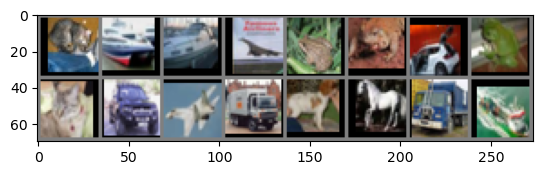

GroundTruth:  cat   ship  ship  plane frog  frog  car   frog  cat   car   plane truck dog   horse truck ship 


In [30]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

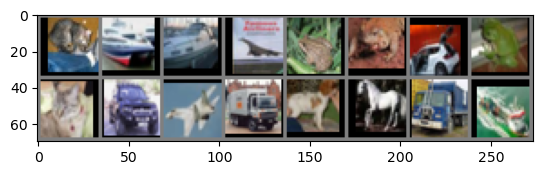

Predicted:  cat   car   ship  plane frog  frog  car   frog  cat   car   plane truck dog   horse truck plane


In [32]:
#Loading previous results
net = Net()
net.load_state_dict(torch.load(PATH))

outputs = net(images)
_, predicted = torch.max(outputs, 1)

#Prédictions
imshow(torchvision.utils.make_grid(images))
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(batch_size)))